# 1d Poisson, 2 output
---
$$
\begin{aligned}
&\frac{d^2 y}{dx^2} = 2, \ x\in [-1, 1], \\
&x(-1) = 0, x(1) = 2.
\end{aligned}
$$

Solution:
$$
y = x^2+x.
$$

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
model = keras.models.Sequential([
	keras.layers.Dense(128, input_shape = (1,), activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(2, use_bias = True)
])

loss_func = keras.losses.MeanSquaredError()

In [3]:
def get_residue_loss(tape, x, y1, y2):
    dy1_dx = tape.gradient(y1, x)
    dy_dxx = tape.gradient(y2, x)
    return loss_func(dy_dxx, 2.0) + loss_func(y2, dy1_dx)

def step(dataset):
	with tf.GradientTape(persistent = True) as tape:
		tape.watch(dataset)
		[x_b, y_b, x_c] = dataset
		
		y_b_pred = model(x_b)
		y_c = model(x_c)
		
		loss_c = get_residue_loss(tape, x_c, y_c[:, 0:1], y_c[:, 1:2])
		loss_br = get_residue_loss(tape, x_b, y_b_pred[:, 0:1], y_b_pred[:, 1:2])
		loss_bv = loss_func(y_b_pred[:, 0:1], y_b)
		loss = w_c*loss_c + w_br*loss_br + w_bv*loss_bv
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))
	del tape
	return loss, loss_c, loss_br, loss_bv

def train(iterations, start_iteration, dataset,print_every = 100, save_every = 10000, save_path = None):
	iteration = start_iteration
	
	while iteration < start_iteration + iterations:
		iteration += 1
		loss = step(dataset)

		if iteration % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c: {:.4e}, br: {:.4e}, bv: {:.4e}".format(get_time(), iteration, *list(loss)))

In [4]:
np.random.seed(1)
x_c = transform(np.random.random((1000, 1)), -1, 1)

f = lambda x: x**2 + x
x_b = np.array([-1, 1]).reshape((-1, 1))
y_b = f(x_b)

dataset = cast_to_tf_constant([x_b, y_b, x_c])

In [5]:
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c = w_br = w_bv = 1.0
iterations = 10000
import time
start_time = time.time()
train(iterations, 0, dataset, 100)
end_time = time.time()
print("Avg duration per epoch:", (end_time-start_time)/iterations)

2020/07/19, 03:38:18, Epoch: 100, Loss: 3.5752e+00, c: 1.1712e+00, br: 2.1841e+00, bv: 2.1993e-01
2020/07/19, 03:38:22, Epoch: 200, Loss: 3.3743e+00, c: 1.1799e+00, br: 2.1858e+00, bv: 8.5516e-03
2020/07/19, 03:38:26, Epoch: 300, Loss: 3.3474e+00, c: 1.1678e+00, br: 2.1721e+00, bv: 7.4860e-03
2020/07/19, 03:38:29, Epoch: 400, Loss: 3.3286e+00, c: 1.1603e+00, br: 2.1619e+00, bv: 6.3688e-03
2020/07/19, 03:38:33, Epoch: 500, Loss: 3.3139e+00, c: 1.1550e+00, br: 2.1536e+00, bv: 5.2685e-03
2020/07/19, 03:38:37, Epoch: 600, Loss: 3.3016e+00, c: 1.1508e+00, br: 2.1465e+00, bv: 4.3148e-03
2020/07/19, 03:38:40, Epoch: 700, Loss: 3.2910e+00, c: 1.1472e+00, br: 2.1403e+00, bv: 3.5429e-03
2020/07/19, 03:38:44, Epoch: 800, Loss: 3.2816e+00, c: 1.1440e+00, br: 2.1347e+00, bv: 2.9280e-03
2020/07/19, 03:38:48, Epoch: 900, Loss: 3.2728e+00, c: 1.1408e+00, br: 2.1296e+00, bv: 2.4321e-03
2020/07/19, 03:38:51, Epoch: 1000, Loss: 3.2638e+00, c: 1.1373e+00, br: 2.1245e+00, bv: 2.0153e-03
2020/07/19, 03:38:5

2020/07/19, 03:42:53, Epoch: 7600, Loss: 9.0255e-05, c: 8.2306e-05, br: 7.0130e-06, bv: 9.3610e-07
2020/07/19, 03:42:56, Epoch: 7700, Loss: 8.5350e-05, c: 7.8612e-05, br: 6.7379e-06, bv: 5.3011e-10
2020/07/19, 03:43:00, Epoch: 7800, Loss: 8.2553e-05, c: 7.5753e-05, br: 6.7153e-06, bv: 8.3932e-08
2020/07/19, 03:43:04, Epoch: 7900, Loss: 7.9243e-05, c: 7.2991e-05, br: 6.2521e-06, bv: 7.6463e-11
2020/07/19, 03:43:07, Epoch: 8000, Loss: 8.7328e-05, c: 7.0442e-05, br: 9.9935e-06, bv: 6.8924e-06
2020/07/19, 03:43:11, Epoch: 8100, Loss: 7.3645e-05, c: 6.7860e-05, br: 5.7840e-06, bv: 1.0081e-09
2020/07/19, 03:43:15, Epoch: 8200, Loss: 2.2439e-04, c: 1.0581e-04, br: 4.5972e-05, bv: 7.2605e-05
2020/07/19, 03:43:18, Epoch: 8300, Loss: 6.8374e-05, c: 6.2996e-05, br: 5.3717e-06, bv: 5.6810e-09
2020/07/19, 03:43:22, Epoch: 8400, Loss: 6.6786e-05, c: 6.0080e-05, br: 6.4644e-06, bv: 2.4139e-07
2020/07/19, 03:43:26, Epoch: 8500, Loss: 6.3676e-05, c: 5.8525e-05, br: 5.0548e-06, bv: 9.6238e-08
2020/07/19

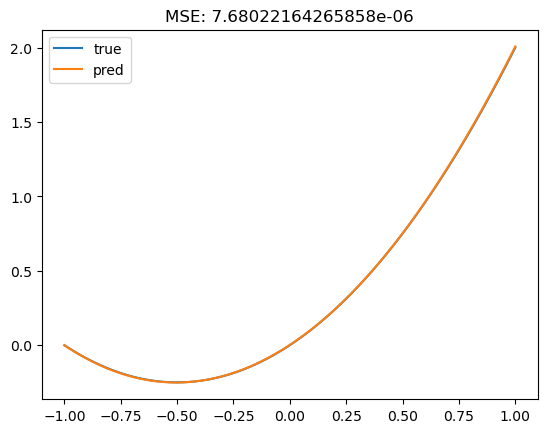

In [7]:
x_test = tf.constant(np.linspace(-1, 1, 100).reshape((-1, 1)), dtype = tf.float32)
y_test = f(x_test)
y_pred = model(x_test)[:, 0:1]

import matplotlib.pyplot as plt
plt.plot(x_test, y_test, label = "true")
plt.plot(x_test, y_pred, label = "pred")
plt.title("MSE: {}".format(np.mean((y_test - y_pred)**2)))
plt.legend()
plt.show()